In [4]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=14bbb559c0df570e172fa6c16858783348ba7ffe25ead7c79372ce9f73b7f748
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [32]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.5 MB/s eta 0:00:00


# **Regresion Logistica**

In [2]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import plotly.express as px

# Cargar datos
data = load_breast_cancer()
X, y = data.data, data.target

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Resultados
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'Confusion Matrix:\n {conf_matrix}')
print(f'Classification Report:\n {classification_report(y_test, y_pred)}')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
fig = px.area(x=fpr, y=tpr, title='ROC Curve', labels={'x':'False Positive Rate', 'y':'True Positive Rate'}, width=600, height=400)
fig.add_scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier')
fig.show()

Accuracy: 0.9824561403508771
ROC AUC: 0.9980893592004703
Confusion Matrix:
 [[ 62   1]
 [  2 106]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



In [5]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql import SparkSession
from sklearn.datasets import load_breast_cancer
import pandas as pd
import plotly.express as px

# Crear sesión Spark
spark = SparkSession.builder.appName("LogisticRegression").getOrCreate()

# Cargar datos
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['label'] = data.target

# Convertir a DataFrame de Spark
spark_df = spark.createDataFrame(df)

# Vector Assembler
assembler = VectorAssembler(inputCols=data.feature_names, outputCol="features")
vector_df = assembler.transform(spark_df)

# Escalar datos
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(vector_df)
scaled_df = scaler_model.transform(vector_df)

# Dividir datos
train_df, test_df = scaled_df.randomSplit([0.7, 0.3], seed=42)

# Modelo de regresión logística
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label')
lr_model = lr.fit(train_df)

# Predicciones
predictions = lr_model.transform(test_df)

# Evaluación del modelo
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy = evaluator.evaluate(predictions)

# Resultados
print(f'Accuracy: {accuracy}')

# Curva ROC
roc = lr_model.summary.roc.toPandas()
fig = px.area(x=roc['FPR'], y=roc['TPR'], title='ROC Curve', labels={'x':'False Positive Rate', 'y':'True Positive Rate'}, width=600, height=400)
fig.add_scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier')
fig.show()

Accuracy: 0.9855287569573283


# **KNN**

In [12]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import plotly.express as px

# Cargar datos
data = load_iris()
X, y = data.data, data.target

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predicciones
y_pred = knn.predict(X_test)
y_pred_prob = knn.predict_proba(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Resultados
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n {conf_matrix}')
print(f'Classification Report:\n {classification_report(y_test, y_pred)}')

# Curva ROC (para cada clase)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=600, height=400
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.show()

Accuracy: 1.0
Confusion Matrix:
 [[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [14]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import plotly.express as px

# Cargar datos
data = load_iris()
X, y = data.data, data.target

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)

# Validación cruzada
cv_scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='accuracy')

print(f'CV Accuracy scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

# Ajuste final del modelo
knn.fit(X_scaled, y)

# Predicciones
y_pred = knn.predict(X_scaled)
y_pred_prob = knn.predict_proba(X_scaled)

# Evaluación del modelo
accuracy = accuracy_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)

# Resultados
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n {conf_matrix}')
print(f'Classification Report:\n {classification_report(y, y_pred)}')

# Curva ROC (para cada clase)
fpr, tpr, _ = roc_curve(y, y_pred_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=600, height=400
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.show()

CV Accuracy scores: [0.96666667 0.96666667 0.93333333 0.93333333 1.        ]
Mean CV Accuracy: 0.96
Accuracy: 0.9533333333333334
Confusion Matrix:
 [[50  0  0]
 [ 0 47  3]
 [ 0  4 46]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.92      0.94      0.93        50
           2       0.94      0.92      0.93        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



In [13]:
from pyspark.sql import SparkSession
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import plotly.express as px

# Crear sesión Spark
spark = SparkSession.builder.appName("KNN").getOrCreate()

# Cargar datos
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['label'] = data.target

# Convertir a DataFrame de Spark
spark_df = spark.createDataFrame(df)

# Convertir a Pandas DataFrame
pandas_df = spark_df.toPandas()

# Separar características y etiqueta
X = pandas_df.drop(columns=['label'])
y = pandas_df['label']

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predicciones
y_pred = knn.predict(X_test)
y_pred_prob = knn.predict_proba(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Resultados
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n {conf_matrix}')
print(f'Classification Report:\n {classification_report(y_test, y_pred)}')

# Curva ROC (para cada clase)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=600, height=400
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.show()

Accuracy: 1.0
Confusion Matrix:
 [[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [15]:
from pyspark.sql import SparkSession
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import plotly.express as px

# Crear sesión Spark
spark = SparkSession.builder.appName("KNN").getOrCreate()

# Cargar datos
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['label'] = data.target

# Convertir a DataFrame de Spark
spark_df = spark.createDataFrame(df)

# Convertir a Pandas DataFrame
pandas_df = spark_df.toPandas()

# Separar características y etiqueta
X = pandas_df.drop(columns=['label'])
y = pandas_df['label']

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)

# Validación cruzada
cv_scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='accuracy')

print(f'CV Accuracy scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

# Ajuste final del modelo
knn.fit(X_scaled, y)

# Predicciones
y_pred = knn.predict(X_scaled)
y_pred_prob = knn.predict_proba(X_scaled)

# Evaluación del modelo
accuracy = accuracy_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)

# Resultados
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n {conf_matrix}')
print(f'Classification Report:\n {classification_report(y, y_pred)}')

# Curva ROC (para cada clase)
fpr, tpr, _ = roc_curve(y, y_pred_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=600, height=400
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.show()

CV Accuracy scores: [0.96666667 0.96666667 0.93333333 0.93333333 1.        ]
Mean CV Accuracy: 0.96
Accuracy: 0.9533333333333334
Confusion Matrix:
 [[50  0  0]
 [ 0 47  3]
 [ 0  4 46]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.92      0.94      0.93        50
           2       0.94      0.92      0.93        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



# **SVM**

In [16]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import plotly.express as px

# Cargar datos
data = load_iris()
X, y = data.data, data.target

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Modelo SVM
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)

# Predicciones
y_pred = svm.predict(X_test)
y_pred_prob = svm.predict_proba(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Resultados
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n {conf_matrix}')
print(f'Classification Report:\n {classification_report(y_test, y_pred)}')

# Curva ROC (para cada clase)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=600, height=400
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.show()

# Validación cruzada
cv_scores = cross_val_score(svm, X_scaled, y, cv=5, scoring='accuracy')
print(f'CV Accuracy scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

Accuracy: 1.0
Confusion Matrix:
 [[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



CV Accuracy scores: [0.96666667 0.96666667 0.96666667 0.93333333 1.        ]
Mean CV Accuracy: 0.9666666666666666


In [20]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn import datasets
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Crear la sesión de Spark
spark = SparkSession.builder.appName('SVM_Classification').getOrCreate()

# Cargar el dataset
iris = datasets.load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data[data[:, -1] != 2], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Preparar los datos
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
data = assembler.transform(df_spark).select('features', 'label')

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(data)
data = scalerModel.transform(data).select('scaledFeatures', 'label').withColumnRenamed('scaledFeatures', 'features')

# Dividir los datos
train, test = data.randomSplit([0.7, 0.3], seed=42)

# Crear el modelo SVM
svm = LinearSVC(maxIter=10, regParam=0.1)

# Configurar la validación cruzada
paramGrid = ParamGridBuilder().addGrid(svm.regParam, [0.1, 0.01]).build()
crossval = CrossValidator(estimator=svm, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=5)

# Entrenar el modelo
cvModel = crossval.fit(train)

# Evaluar el modelo
predictions = cvModel.transform(test)
evaluator = BinaryClassificationEvaluator()
roc_auc = evaluator.evaluate(predictions)
print(f'ROC AUC: {roc_auc}')

# Mostrar la matriz de confusión
predictions.groupBy('label', 'prediction').count().show()

# Visualización (ejemplo simple, PySpark no tiene soporte nativo para plotly)
roc = predictions.select('label', 'rawPrediction')
roc_pd = roc.toPandas()
fpr, tpr, _ = roc_curve(roc_pd['label'], roc_pd['rawPrediction'].apply(lambda x: x[1]))
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

ROC AUC: 1.0
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|   24|
|  1.0|       1.0|   17|
+-----+----------+-----+



# **Naive Bayes**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



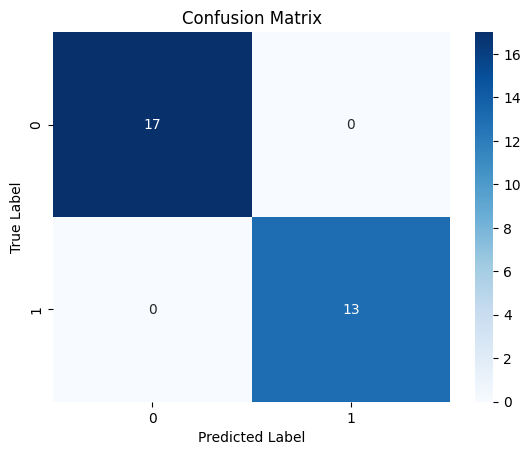

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import plotly.graph_objects as go

# Cargar el dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Solo vamos a clasificar dos clases para simplificar
X = X[y != 2]
y = y[y != 2]

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo Naive Bayes
model = GaussianNB()

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

In [22]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn import datasets
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Crear la sesión de Spark
spark = SparkSession.builder.appName('NaiveBayes_Classification').getOrCreate()

# Cargar el dataset
iris = datasets.load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data[data[:, -1] != 2], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Preparar los datos
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
data = assembler.transform(df_spark).select('features', 'label')

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(data)
data = scalerModel.transform(data).select('scaledFeatures', 'label').withColumnRenamed('scaledFeatures', 'features')

# Dividir los datos
train, test = data.randomSplit([0.7, 0.3], seed=42)

# Crear el modelo Naive Bayes
nb = NaiveBayes(modelType='gaussian')

# Configurar la validación cruzada
paramGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=nb, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=5)

# Entrenar el modelo
cvModel = crossval.fit(train)

# Evaluar el modelo
predictions = cvModel.transform(test)
evaluator = BinaryClassificationEvaluator()
roc_auc = evaluator.evaluate(predictions)
print(f'ROC AUC: {roc_auc}')

# Mostrar la matriz de confusión
predictions.groupBy('label', 'prediction').count().show()

# Visualización (ejemplo simple, PySpark no tiene soporte nativo para plotly)
roc = predictions.select('label', 'probability')
roc_pd = roc.toPandas()
fpr, tpr, _ = roc_curve(roc_pd['label'], roc_pd['probability'].apply(lambda x: x[1]))
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

ROC AUC: 1.0
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|   24|
|  1.0|       1.0|   17|
+-----+----------+-----+



# **Arbol de decision**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



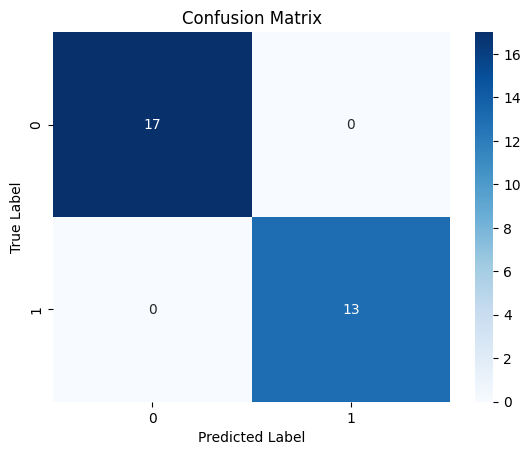

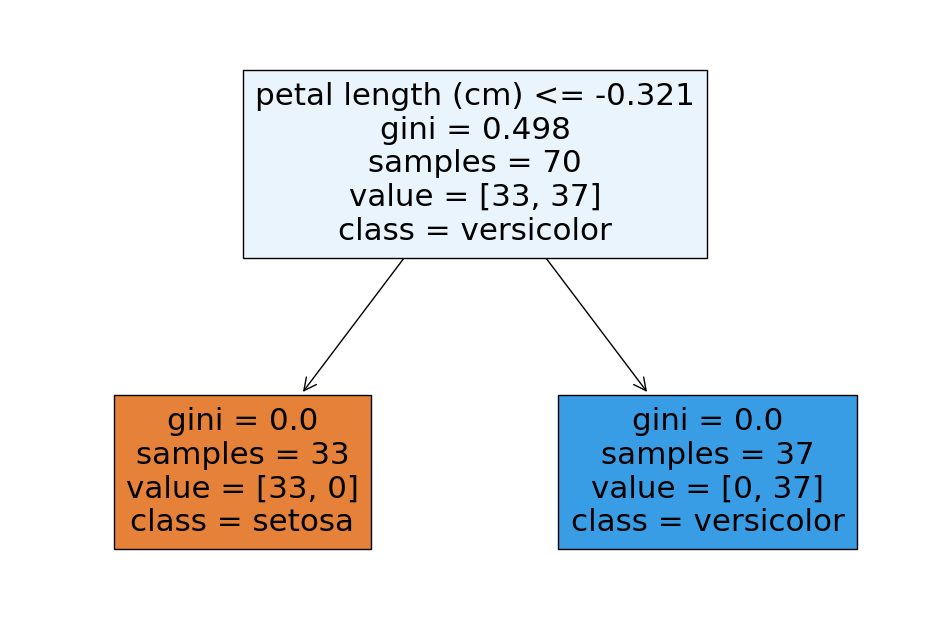

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import plotly.graph_objects as go
from sklearn import tree

# Cargar el dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Solo vamos a clasificar dos clases para simplificar
X = X[y != 2]
y = y[y != 2]

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo de árbol de decisión
model = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

# Visualización del árbol
plt.figure(figsize=(12,8))
tree.plot_tree(model, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show()

In [24]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn import datasets
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Crear la sesión de Spark
spark = SparkSession.builder.appName('DecisionTree_Classification').getOrCreate()

# Cargar el dataset
iris = datasets.load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data[data[:, -1] != 2], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Preparar los datos
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
data = assembler.transform(df_spark).select('features', 'label')

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(data)
data = scalerModel.transform(data).select('scaledFeatures', 'label').withColumnRenamed('scaledFeatures', 'features')

# Dividir los datos
train, test = data.randomSplit([0.7, 0.3], seed=42)

# Crear el modelo de árbol de decisión
dt = DecisionTreeClassifier(labelCol='label', featuresCol='features', maxDepth=3)

# Configurar la validación cruzada
paramGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=5)

# Entrenar el modelo
cvModel = crossval.fit(train)

# Evaluar el modelo
predictions = cvModel.transform(test)
evaluator = BinaryClassificationEvaluator()
roc_auc = evaluator.evaluate(predictions)
print(f'ROC AUC: {roc_auc}')

# Mostrar la matriz de confusión
predictions.groupBy('label', 'prediction').count().show()

# Visualización (ejemplo simple, PySpark no tiene soporte nativo para plotly)
roc = predictions.select('label', 'probability')
roc_pd = roc.toPandas()
fpr, tpr, _ = roc_curve(roc_pd['label'], roc_pd['probability'].apply(lambda x: x[1]))
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

ROC AUC: 1.0
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|   24|
|  1.0|       1.0|   17|
+-----+----------+-----+



# **Random Forest**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



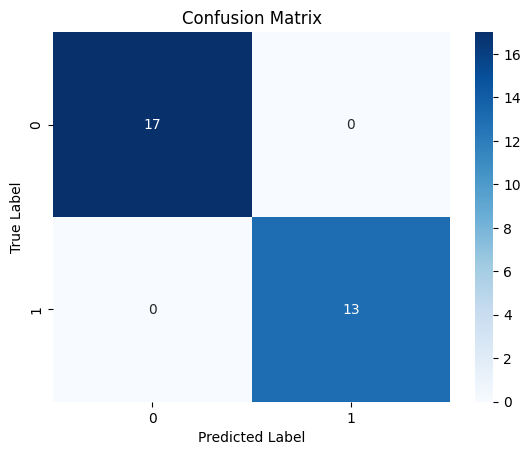

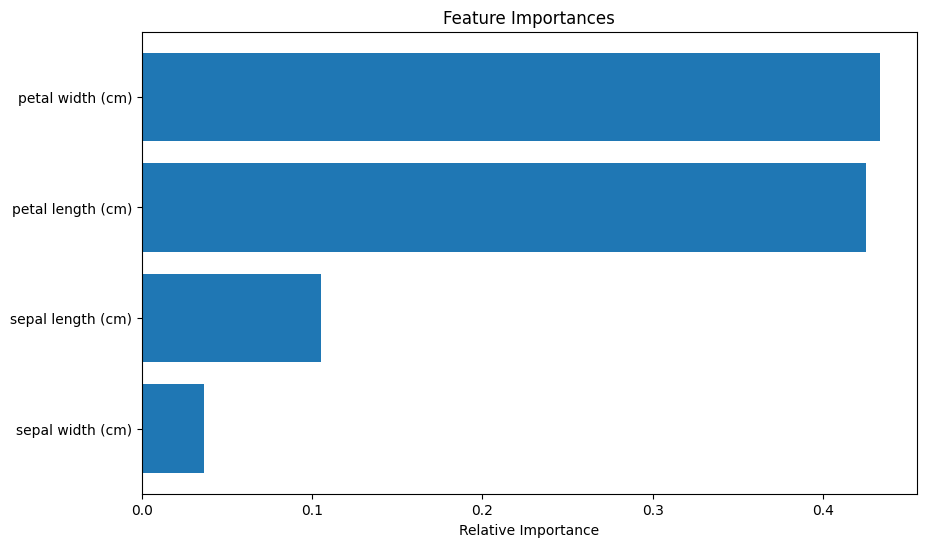

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import plotly.graph_objects as go

# Cargar el dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Solo vamos a clasificar dos clases para simplificar
X = X[y != 2]
y = y[y != 2]

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo Random Forest
model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

# Importancia de características
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [iris.feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [26]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn import datasets
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Crear la sesión de Spark
spark = SparkSession.builder.appName('RandomForest_Classification').getOrCreate()

# Cargar el dataset
iris = datasets.load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data[data[:, -1] != 2], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Preparar los datos
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
data = assembler.transform(df_spark).select('features', 'label')

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(data)
data = scalerModel.transform(data).select('scaledFeatures', 'label').withColumnRenamed('scaledFeatures', 'features')

# Dividir los datos
train, test = data.randomSplit([0.7, 0.3], seed=42)

# Crear el modelo Random Forest
rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=100, maxDepth=3, seed=42)

# Configurar la validación cruzada
paramGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=5)

# Entrenar el modelo
cvModel = crossval.fit(train)

# Evaluar el modelo
predictions = cvModel.transform(test)
evaluator = BinaryClassificationEvaluator()
roc_auc = evaluator.evaluate(predictions)
print(f'ROC AUC: {roc_auc}')

# Mostrar la matriz de confusión
predictions.groupBy('label', 'prediction').count().show()

# Visualización (ejemplo simple, PySpark no tiene soporte nativo para plotly)
roc = predictions.select('label', 'probability')
roc_pd = roc.toPandas()
fpr, tpr, _ = roc_curve(roc_pd['label'], roc_pd['probability'].apply(lambda x: x[1]))
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

ROC AUC: 1.0
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|   24|
|  1.0|       1.0|   17|
+-----+----------+-----+



# **GradientBoost**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



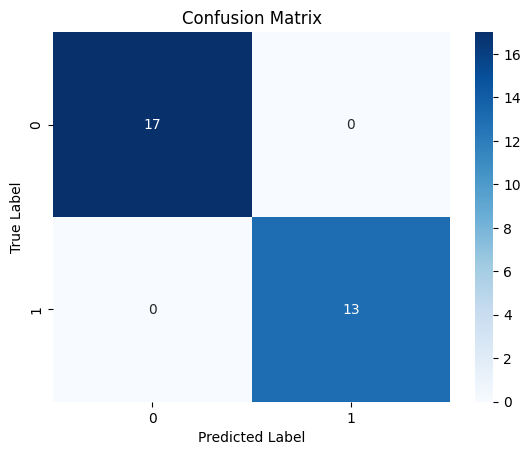

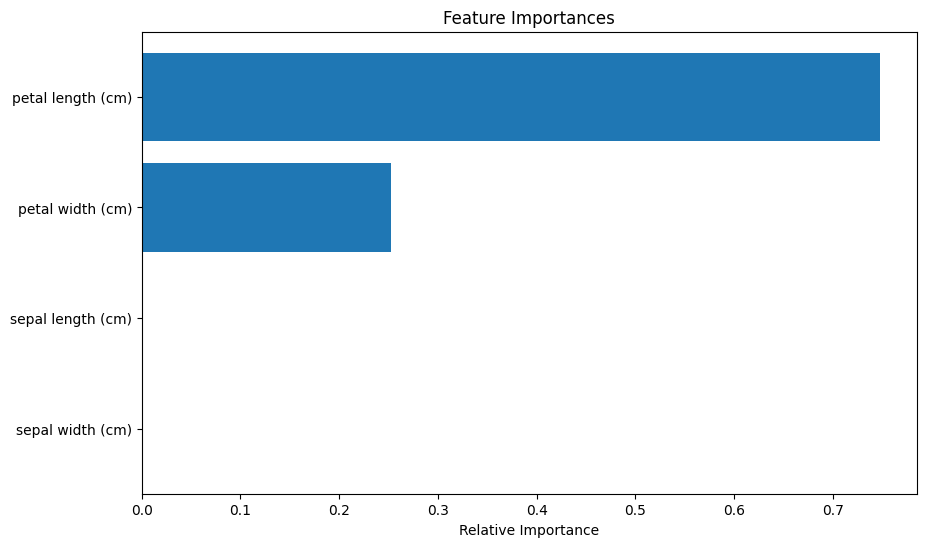

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import plotly.graph_objects as go

# Cargar el dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Solo vamos a clasificar dos clases para simplificar
X = X[y != 2]
y = y[y != 2]

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo Gradient Boosting
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

# Importancia de características
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [iris.feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [28]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn import datasets
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Crear la sesión de Spark
spark = SparkSession.builder.appName('GradientBoosting_Classification').getOrCreate()

# Cargar el dataset
iris = datasets.load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data[data[:, -1] != 2], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Preparar los datos
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
data = assembler.transform(df_spark).select('features', 'label')

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(data)
data = scalerModel.transform(data).select('scaledFeatures', 'label').withColumnRenamed('scaledFeatures', 'features')

# Dividir los datos
train, test = data.randomSplit([0.7, 0.3], seed=42)

# Crear el modelo Gradient Boosting
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=100, maxDepth=3)

# Configurar la validación cruzada
paramGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=5)

# Entrenar el modelo
cvModel = crossval.fit(train)

# Evaluar el modelo
predictions = cvModel.transform(test)
evaluator = BinaryClassificationEvaluator()
roc_auc = evaluator.evaluate(predictions)
print(f'ROC AUC: {roc_auc}')

# Mostrar la matriz de confusión
predictions.groupBy('label', 'prediction').count().show()

# Visualización (ejemplo simple, PySpark no tiene soporte nativo para plotly)
roc = predictions.select('label', 'probability')
roc_pd = roc.toPandas()
fpr, tpr, _ = roc_curve(roc_pd['label'], roc_pd['probability'].apply(lambda x: x[1]))
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

ROC AUC: 1.0
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|   24|
|  1.0|       1.0|   17|
+-----+----------+-----+



# **XGBoost**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



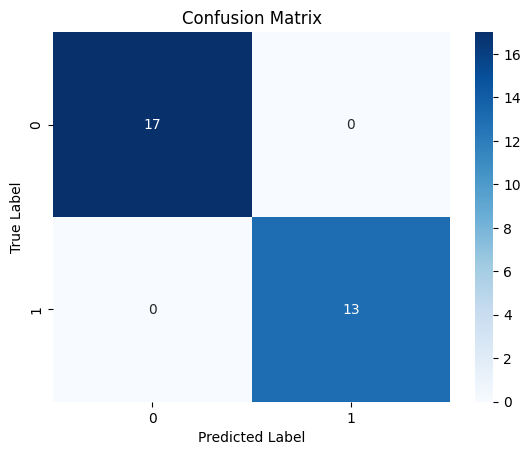

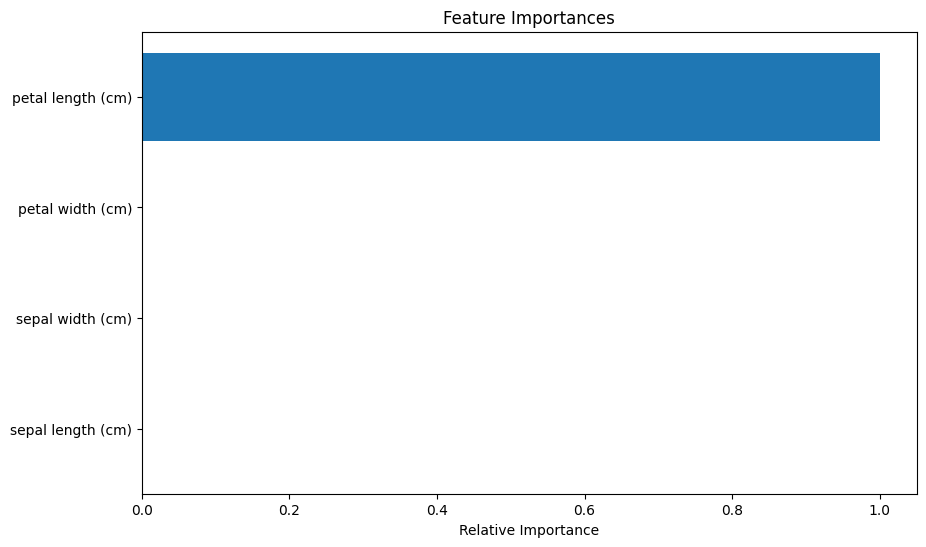

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import plotly.graph_objects as go

# Cargar el dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Solo vamos a clasificar dos clases para simplificar
X = X[y != 2]
y = y[y != 2]

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo XGBoost
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False)

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

# Importancia de características
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [iris.feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [30]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn import datasets
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Crear la sesión de Spark
spark = SparkSession.builder.appName('XGBoost_Classification').getOrCreate()

# Cargar el dataset
iris = datasets.load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data[data[:, -1] != 2], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Preparar los datos
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
data = assembler.transform(df_spark).select('features', 'label')

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(data)
data = scalerModel.transform(data).select('scaledFeatures', 'label').withColumnRenamed('scaledFeatures', 'features')

# Dividir los datos
train, test = data.randomSplit([0.7, 0.3], seed=42)

# Crear el modelo Gradient Boosting
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=100, maxDepth=3)

# Configurar la validación cruzada
paramGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=5)

# Entrenar el modelo
cvModel = crossval.fit(train)

# Evaluar el modelo
predictions = cvModel.transform(test)
evaluator = BinaryClassificationEvaluator()
roc_auc = evaluator.evaluate(predictions)
print(f'ROC AUC: {roc_auc}')

# Mostrar la matriz de confusión
predictions.groupBy('label', 'prediction').count().show()

# Visualización (ejemplo simple, PySpark no tiene soporte nativo para plotly)
roc = predictions.select('label', 'probability')
roc_pd = roc.toPandas()
fpr, tpr, _ = roc_curve(roc_pd['label'], roc_pd['probability'].apply(lambda x: x[1]))
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

ROC AUC: 1.0
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|   24|
|  1.0|       1.0|   17|
+-----+----------+-----+



# **Catboost**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



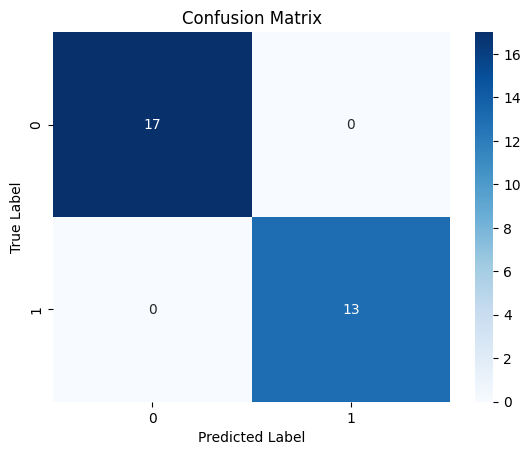

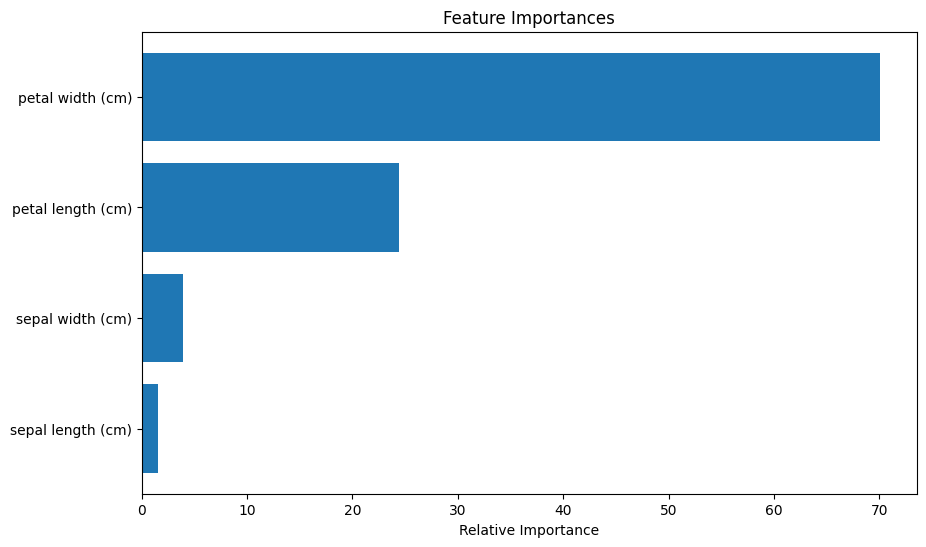

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import plotly.graph_objects as go

# Cargar el dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Solo vamos a clasificar dos clases para simplificar
X = X[y != 2]
y = y[y != 2]

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo CatBoost
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, eval_metric='AUC', random_seed=42, verbose=0)

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

# Importancia de características
importances = model.get_feature_importance()
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [iris.feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [34]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn import datasets
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Crear la sesión de Spark
spark = SparkSession.builder.appName('CatBoost_Classification').getOrCreate()

# Cargar el dataset
iris = datasets.load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data[data[:, -1] != 2], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Preparar los datos
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
data = assembler.transform(df_spark).select('features', 'label')

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(data)
data = scalerModel.transform(data).select('scaledFeatures', 'label').withColumnRenamed('scaledFeatures', 'features')

# Dividir los datos
train, test = data.randomSplit([0.7, 0.3], seed=42)

# Crear el modelo Gradient Boosting
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=100, maxDepth=3)

# Configurar la validación cruzada
paramGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=5)

# Entrenar el modelo
cvModel = crossval.fit(train)

# Evaluar el modelo
predictions = cvModel.transform(test)
evaluator = BinaryClassificationEvaluator()
roc_auc = evaluator.evaluate(predictions)
print(f'ROC AUC: {roc_auc}')

# Mostrar la matriz de confusión
predictions.groupBy('label', 'prediction').count().show()

# Visualización (ejemplo simple, PySpark no tiene soporte nativo para plotly)
roc = predictions.select('label', 'probability')
roc_pd = roc.toPandas()
fpr, tpr, _ = roc_curve(roc_pd['label'], roc_pd['probability'].apply(lambda x: x[1]))
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

ROC AUC: 1.0
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|   24|
|  1.0|       1.0|   17|
+-----+----------+-----+



# **LightGBM**

[LightGBM] [Info] Number of positive: 37, number of negative: 33
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65
[LightGBM] [Info] Number of data points in the train set: 70, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528571 -> initscore=0.114410
[LightGBM] [Info] Start training from score 0.114410
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

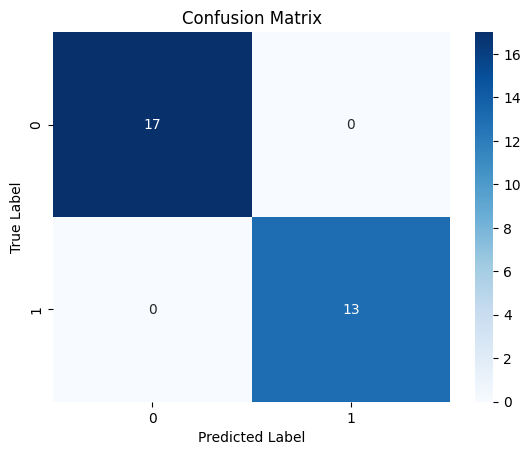

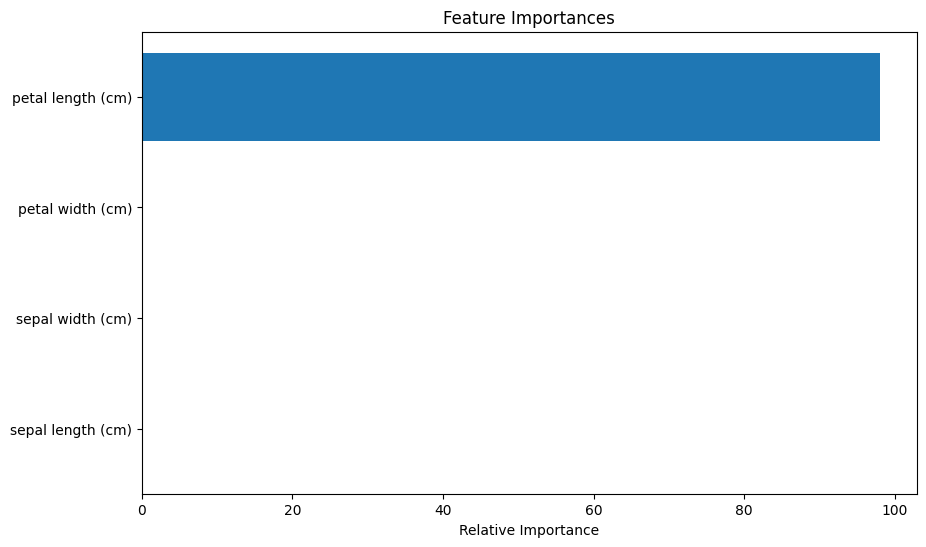

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import plotly.graph_objects as go

# Cargar el dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Solo vamos a clasificar dos clases para simplificar
X = X[y != 2]
y = y[y != 2]

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo LightGBM
model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

# Importancia de características
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [iris.feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [36]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn import datasets
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Crear la sesión de Spark
spark = SparkSession.builder.appName('LightGBM_Classification').getOrCreate()

# Cargar el dataset
iris = datasets.load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data[data[:, -1] != 2], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Preparar los datos
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
data = assembler.transform(df_spark).select('features', 'label')

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(data)
data = scalerModel.transform(data).select('scaledFeatures', 'label').withColumnRenamed('scaledFeatures', 'features')

# Dividir los datos
train, test = data.randomSplit([0.7, 0.3], seed=42)

# Crear el modelo Gradient Boosting (LightGBM no está directamente disponible en PySpark, usamos GBTClassifier)
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=100, maxDepth=3)

# Configurar la validación cruzada
paramGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=5)

# Entrenar el modelo
cvModel = crossval.fit(train)

# Evaluar el modelo
predictions = cvModel.transform(test)
evaluator = BinaryClassificationEvaluator()
roc_auc = evaluator.evaluate(predictions)
print(f'ROC AUC: {roc_auc}')

# Mostrar la matriz de confusión
predictions.groupBy('label', 'prediction').count().show()

# Visualización (ejemplo simple, PySpark no tiene soporte nativo para plotly)
roc = predictions.select('label', 'probability')
roc_pd = roc.toPandas()
fpr, tpr, _ = roc_curve(roc_pd['label'], roc_pd['probability'].apply(lambda x: x[1]))
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random guess', line=dict(dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  showlegend=True)
fig.show()

ROC AUC: 1.0
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|   24|
|  1.0|       1.0|   17|
+-----+----------+-----+

